<a href="https://colab.research.google.com/github/djfLtC0dr/python-playground/blob/main/DASC522/djfDASC522_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   A. Data loading and clean-up => drop 'Flight'
*   c. Create a Data Understanding table & include 3 Data Understanding visualizations

In [11]:
# importing libraries
import sklearn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score as rocauc
import warnings
warnings.filterwarnings('ignore')

# loading the training dataset 
data = pd.read_csv('/LRS_Pre_Assessment_trimmed_rank.csv')
# data.info()
data.drop(columns=['Flight'], axis=1, inplace=True)
# print(data)
# data.info()
# data.drop(columns=['Flight'], axis=1, inplace=True)
# data_encoded = pd.get_dummies(data, columns = ['Rank','Gender'])
# print(data_encoded)

data.describe()

,Age,ORS_total,PTSD_score,Sleep_score,survey_Burnout,survey_FitSat,BMI,BodyFatPerc,MusclePerc,APFT_1_is_pass
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,27.942675,7.620382,9.312102,7.305732,2.140127,3.331210,27.110191,0.294873,0.327968,0.707006
std,6.164666,1.955621,11.795182,3.939710,0.812235,0.803746,4.093791,0.086974,0.060547,0.456592
min,19.000000,0.200000,0.000000,0.000000,1.000000,1.000000,18.400000,0.014700,0.036500,0.000000
25%,23.000000,6.700000,1.000000,4.000000,2.000000,3.000000,24.400000,0.248000,0.289000,0.000000
50%,26.000000,8.000000,5.000000,7.000000,2.000000,3.000000,27.100000,0.296000,0.334000,1.000000
75%,33.000000,9.000000,12.000000,10.000000,2.000000,4.000000,29.700000,0.346000,0.366000,1.000000
max,45.000000,10.000000,68.000000,22.000000,5.000000,5.000000,38.300000,0.495000,0.473000,1.000000


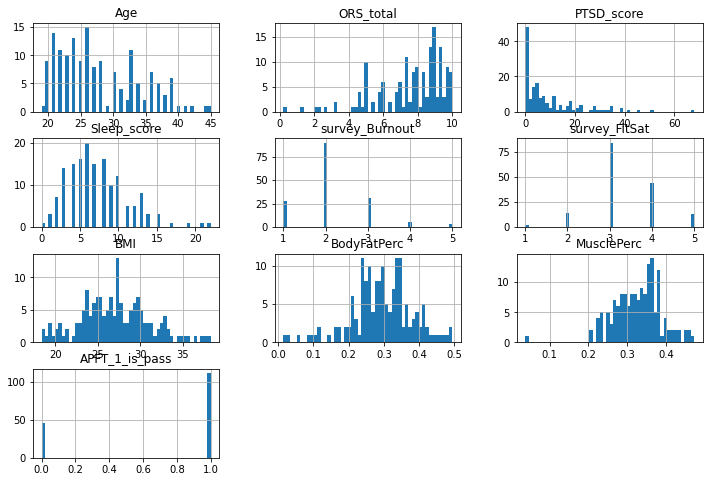

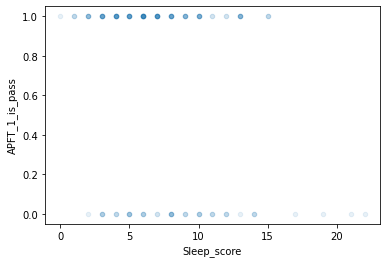

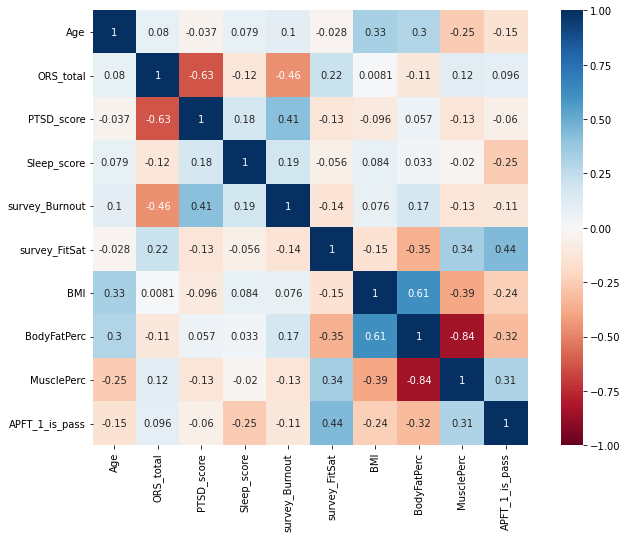

In [3]:
#histplot
data.hist(bins=50, figsize=(12,8))

# scatterplot by Sleep_score
data.plot(kind='scatter', x='Sleep_score', y='APFT_1_is_pass', alpha=0.1)
plt.show()

# correlation matrix
corr_matrix = data.corr()
#apft_corr = np.asarray(corr_matrix['APFT_1_is_pass']).reshape(15,1)
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(corr_matrix, cmap='RdBu', vmin=-1, vmax=1, annot=True, square=True, ax=ax)

# separate the independent and dependent variables
X = data.loc[:, data.columns != 'APFT_1_is_pass']
y = data.loc[:, data.columns == 'APFT_1_is_pass']

*   b. one-hot-encode the “rank” & “gender” *columns*
*   d. Data Preparation
*   e. Modeling



In [45]:
from typing import List
def get_feature_names(mask, all_features) -> List[str]:
  impt_features = [] # The list of your K best features
  for bool, feature in zip(mask, all_features):
      if bool:
          impt_features.append(feature)
  return impt_features

def get_impt_features(pipe) -> List[str]:
  selector = pipe.named_steps['selector']
  all_features = [*categorical_features, *numeric_features]  # unpack both iterables in a list literal
  mask = selector.get_support()
  df_features = pd.DataFrame()
  df_features['pval'] = selector.pvalues_
  df_features['fscore'] = selector.scores_
  df_features['impt'] = mask
  df_features['feat_name'] = get_column_names_from_ColumnTransformer(preprocessor, verbose=False) #pd.Series(get_feature_names(mask, all_features))
  df_features.sort_values(by=['pval'], inplace=True)
  return df_features

# for future piping
df_nbr = X.select_dtypes(exclude=['object'])
numeric_features = df_nbr.columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

df_cat = X.select_dtypes(include=['object'])
categorical_features = df_cat.columns.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# feature pipelines
pipe_lr_all=Pipeline(steps=[('preprocessor', preprocessor),
                  ('vt', VarianceThreshold(0.01)),
                  ('selector', SelectKBest(f_classif, k='all')), # feature selection procedure  
                  ('classifier', LogisticRegression(solver='lbfgs'))])

pipe_lr_best=Pipeline(steps=[('preprocessor', preprocessor),
                  ('vt', VarianceThreshold(0.01)),
                  ('selector', SelectKBest(f_classif, k=5)), # feature selection procedure                                       
                  ('classifier', LogisticRegression(solver='lbfgs'))])

# split normd data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

pipelines = [pipe_lr_all, pipe_lr_best] #pipe_rf
pipe_dict = {0: 'Logistic Regression All Features', 1: 'Logistic Regression Best Features'}
for pipe in pipelines:
  pipe.fit(X_train, y_train)
  y_test_pred = pipe.predict(X_test)
  # get best features
  kbest_features = get_impt_features(pipe)
  print(kbest_features)
for i,model in enumerate(pipelines):
    print("{} Test Accuracy:{}".format(pipe_dict[i],model.score(X_test,y_test)))

        pval     fscore  impt         feat_name
5   0.000005  23.251731  True    survey_fit_sat
7   0.000274  14.166888  True     body_fat_perc
8   0.000453  13.100720  True       muscle_perc
6   0.000617  12.452546  True               bmi
3   0.005429   8.055662  True       sleep_score
11  0.021289   5.462605  True          gender_m
4   0.051826   3.867287  True    survey_burnout
0   0.088351   2.957891  True               age
10  0.192340   1.721252  True      rank_officer
9   0.233900   1.433130  True  rank_sr_enlisted
1   0.309389   1.043169  True         ors_total
2   0.635955   0.225358  True        ptsd_score
        pval     fscore   impt         feat_name
5   0.000005  23.251731   True    survey_fit_sat
7   0.000274  14.166888   True     body_fat_perc
8   0.000453  13.100720   True       muscle_perc
6   0.000617  12.452546   True               bmi
3   0.005429   8.055662   True       sleep_score
11  0.021289   5.462605  False          gender_m
4   0.051826   3.867287  False   

ROC Scoring

In [16]:
# get ROC AUC score https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
y_train_pred = pipe_lr_all.predict(X_train)
rocscore = rocauc(y_train, y_train_pred)

#print results
print(f'Overall Accuracy: {100*pipe_lr_all.score(X_train, y_train)}%')
print(f'ROC AUC Score: {100*rocscore}%')
# print(classification_report(y_test, y_test_pred))

Overall Accuracy: 81.65137614678899%
ROC AUC Score: 75.14204545454545%


Tinkering w/ feature names

In [41]:
!pip install skimpy
from skimpy import clean_columns
from sklearn.utils.validation import check_is_fitted

def get_column_names_from_ColumnTransformer(column_transformer, clean_column_names=True, verbose=True):  

    """
    Reference: Kyle Gilde: https://github.com/kylegilde/Kaggle-Notebooks/blob/master/Extracting-and-Plotting-Scikit-Feature-Names-and-Importances/feature_importance.py
    Description: Get the column names from the a ColumnTransformer containing transformers & pipelines
    Parameters
    ----------
    verbose: Bool indicating whether to print summaries. Default set to True.
    Returns
    -------
    a list of the correct feature names
    Note:
    If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns,
    it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns
    to the dataset that didn't exist before, so there should come last in the Pipeline.
    Inspiration: https://github.com/scikit-learn/scikit-learn/issues/12525
    """

    assert isinstance(column_transformer, ColumnTransformer), "Input isn't a ColumnTransformer"
    
    check_is_fitted(column_transformer)

    new_feature_names, transformer_list = [], []

    for i, transformer_item in enumerate(column_transformer.transformers_): 
        transformer_name, transformer, orig_feature_names = transformer_item
        orig_feature_names = list(orig_feature_names)

        if len(orig_feature_names) == 0:
            continue

        if verbose: 
            print(f"\n\n{i}.Transformer/Pipeline: {transformer_name} {transformer.__class__.__name__}\n")
            print(f"\tn_orig_feature_names:{len(orig_feature_names)}")

        if transformer == 'drop':
            continue

        if isinstance(transformer, Pipeline):
            # if pipeline, get the last transformer in the Pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            if 'input_features' in transformer.get_feature_names_out.__code__.co_varnames:
                names = list(transformer.get_feature_names_out(orig_feature_names))
            else:
                names = list(transformer.get_feature_names_out())
        elif hasattr(transformer, 'get_feature_names'):
            if 'input_features' in transformer.get_feature_names.__code__.co_varnames:
                names = list(transformer.get_feature_names(orig_feature_names))
            else:
                names = list(transformer.get_feature_names())

        elif hasattr(transformer,'indicator_') and transformer.add_indicator:
            # is this transformer one of the imputers & did it call the MissingIndicator?

            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                  for idx in missing_indicator_indices]
            names = orig_feature_names + missing_indicators

        elif hasattr(transformer,'features_'):
            # is this a MissingIndicator class? 
            missing_indicator_indices = transformer.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                  for idx in missing_indicator_indices]

        else:

            names = orig_feature_names

        if verbose: 
            print(f"\tn_new_features:{len(names)}")
            print(f"\tnew_features: {names}\n")

        new_feature_names.extend(names)
        transformer_list.extend([transformer_name] * len(names))

    transformer_list, column_transformer_features = transformer_list, new_feature_names

    if clean_column_names:
        new_feature_names = list(clean_columns(pd.DataFrame(columns=new_feature_names)).columns)
    
    return new_feature_names

def extract_feature_names(model, name) -> List[str]:
  """Extracts the feature names from arbitrary sklearn models
  Args:
    model: The Sklearn model, transformer, clustering algorithm, etc. which we want to get named features for.
    name: The name of the current step in the pipeline we are at.
    
  Returns:
    The list of feature names.  If the model does not have named features it constructs feature names
    by appending an index to the provided name.
  """
  if hasattr(model, "get_feature_names"):
      return model.get_feature_names()
  elif hasattr(model, "n_clusters"):
      return [f"{name}_{x}" for x in range(model.n_clusters)]
  elif hasattr(model, "n_components"):
      return [f"{name}_{x}" for x in range(model.n_components)]
  elif hasattr(model, "components_"):
      n_components = model.components_.shape[0]
      return [f"{name}_{x}" for x in range(n_components)]
  elif hasattr(model, "classes_"):
      return model.classes_
  else:
      return [name]

from sklearn.pipeline import FeatureUnion, Pipeline
def get_feature_names(model, names: List[str], name: str) -> List[str]:
    """Thie method extracts the feature names in order from a Sklearn Pipeline
    
    This method only works with composed Pipelines and FeatureUnions.  It will
    pull out all names using DFS from a model.
    
    Args:
        model: The model we are interested in
        names: The list of names of final featurizaiton steps
        name: The current name of the step we want to evaluate.
    
    Returns:
        feature_names: The list of feature names extracted from the pipeline.
    """
    
    # Check if the name is one of our feature steps.  This is the base case.
    if name in names:
        # If it has the named_steps atribute it's a pipeline and we need to access the features
        if hasattr(model, "named_steps"):
            return extract_feature_names(model.named_steps[name], name)
        # Otherwise get the feature directly
        else:
            return extract_feature_names(model, name)
    elif type(model) is Pipeline:
        feature_names = []
        for name in model.named_steps.keys():
            feature_names += get_feature_names(model.named_steps[name], names, name)
        return feature_names
    elif type(model) is FeatureUnion:
        feature_names= []
        for name, new_model in model.transformer_list:
            feature_names += get_feature_names(new_model, names, name)
        return feature_names
    # If it is none of the above do not add it.
    else:
        return []

# get_feature_names(model_lr_scaled,'lr_classifier','lr_classifier')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 37.0 MB/s 
     |████████████████████████████████| 51 kB 5.9 MB/s 
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
